In [1]:
import covasim as cv
import numpy as np

Covasim 3.1.1 (2021-12-06) — © 2021 by IDM


In [2]:
cv.options.set(dpi=100, show=False, close=True, verbose=0) # Standard options for Jupyter notebook

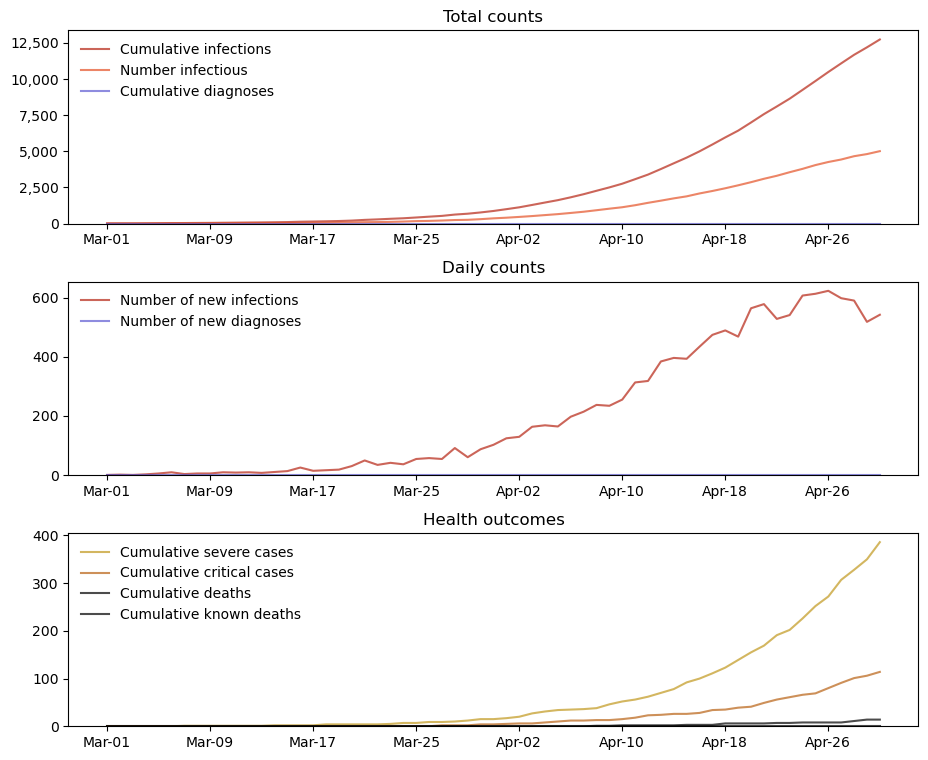

In [3]:
## Default parameters
# Source: https://docs.idmod.org/projects/covasim/en/latest/tutorials/tut_intro.html

sim = cv.Sim()
sim.run()
sim.plot()

In [4]:
# hybrid model
# Source: https://docs.idmod.org/projects/covasim/en/latest/tutorials/tut_running.html

In [5]:
pars = dict(
    pop_type = 'hybrid', # Use a more realistic population model
    location = 'India-TamilNadu', # Use population characteristics for Tamil-Nadu
    pop_size = 10_000, # Have 4 million people total in the population
    pop_scale = 7,
    rescale = True,
    pop_infected = 2000, # Start with 100 infected people

    start_day = '2021-10-01',
    end_day = '2021-11-30',
#     verbose = 0, # Do not print any output
)

In [6]:
sim = cv.Sim(pars)
msim = cv.MultiSim(sim)
msim.run(n_runs=1)

MultiSim(n_sims: 1; base: Sim(<no label>; 2021-10-01 to 2021-11-30; pop: 10000 hybrid; epi: not run))

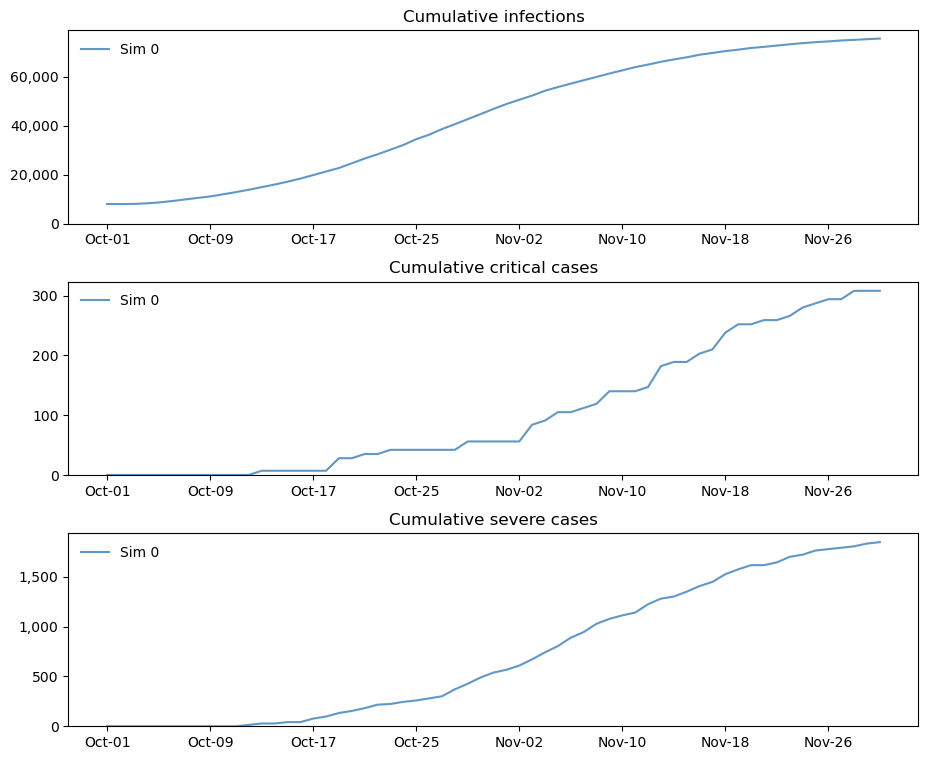

In [7]:
msim.plot(to_plot=['cum_infections', 'cum_critical','cum_severe'])
# number of hospital beds required, number of critical case.0

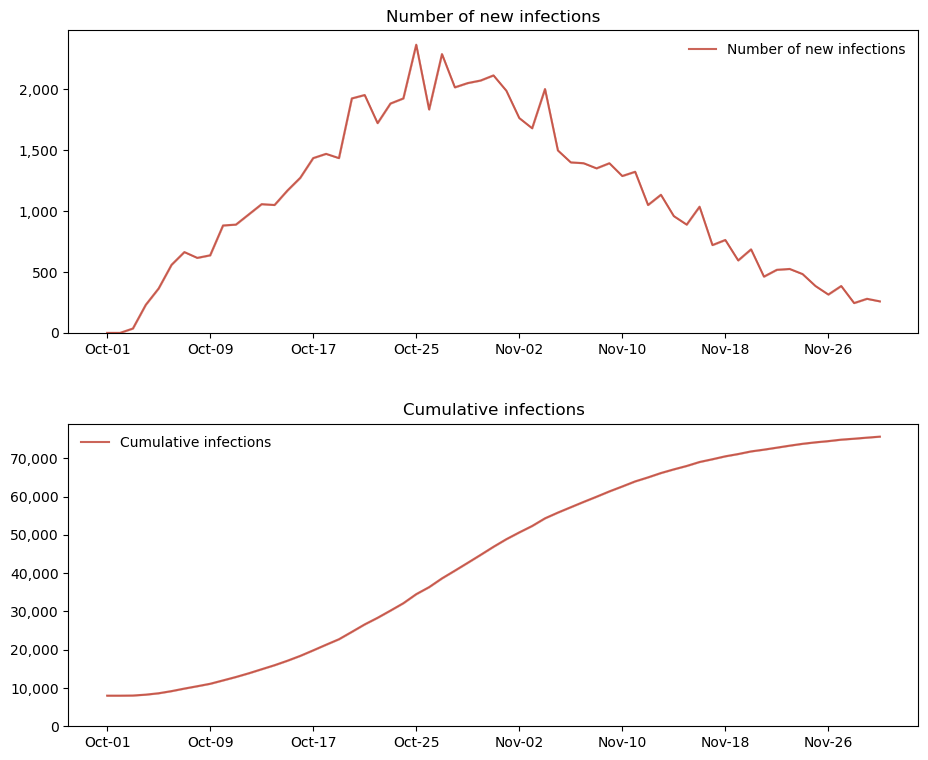

In [8]:
msim.mean()
msim.plot(to_plot=['new_infections', 'cum_infections']) # confidence bound of 80%

In [9]:
# vaccine by age
# https://github.com/InstituteforDiseaseModeling/covasim/blob/master/examples/t05_vaccine_subtargeting.py

In [10]:
def vaccinate_by_age(sim):
    young  = cv.true(sim.people.age < 40)
    middle = cv.true((sim.people.age >= 40) * (sim.people.age < 60)) 
    old    = cv.true(sim.people.age > 60)
    inds = sim.people.uid
    vals = np.ones(len(sim.people))
    vals[young] = 0.1 # 10% probability for people <50
    vals[middle] = 0.5 # 50% probability for people 50-75
    vals[old] = 0.9 # 90% probbaility for people >75
    output = dict(inds=inds, vals=vals)
    return output

vaccine = cv.simple_vaccine(days=20, rel_sus=0.7, rel_symp=0.6, subtarget=vaccinate_by_age)
# consider reduction in critical cases ??

In [11]:
sim1 = cv.Sim(pars=pars, label='Baseline')
sim2 = cv.Sim(pars=pars, interventions=vaccine, label='With age-targeted vaccine')
msim = cv.MultiSim([sim1, sim2])
msim.run()

MultiSim("Baseline"; n_sims: 2; base: Sim("Baseline"; 2021-10-01 to 2021-11-30; pop: 10000 hybrid; epi: not run))

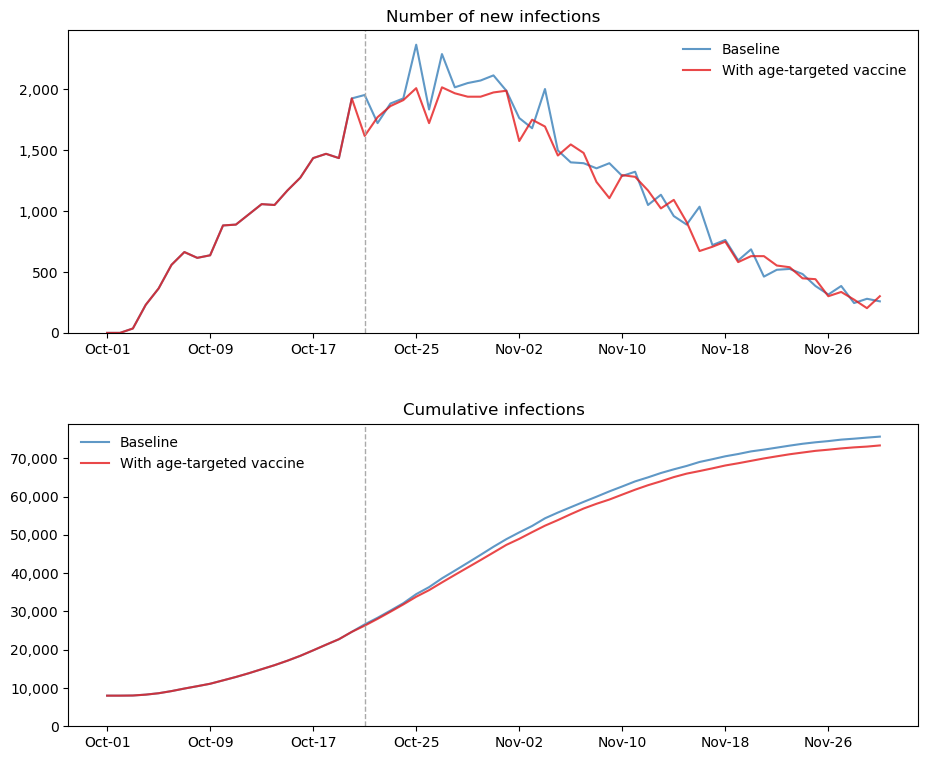

In [12]:
msim.plot(to_plot=['new_infections', 'cum_infections'])

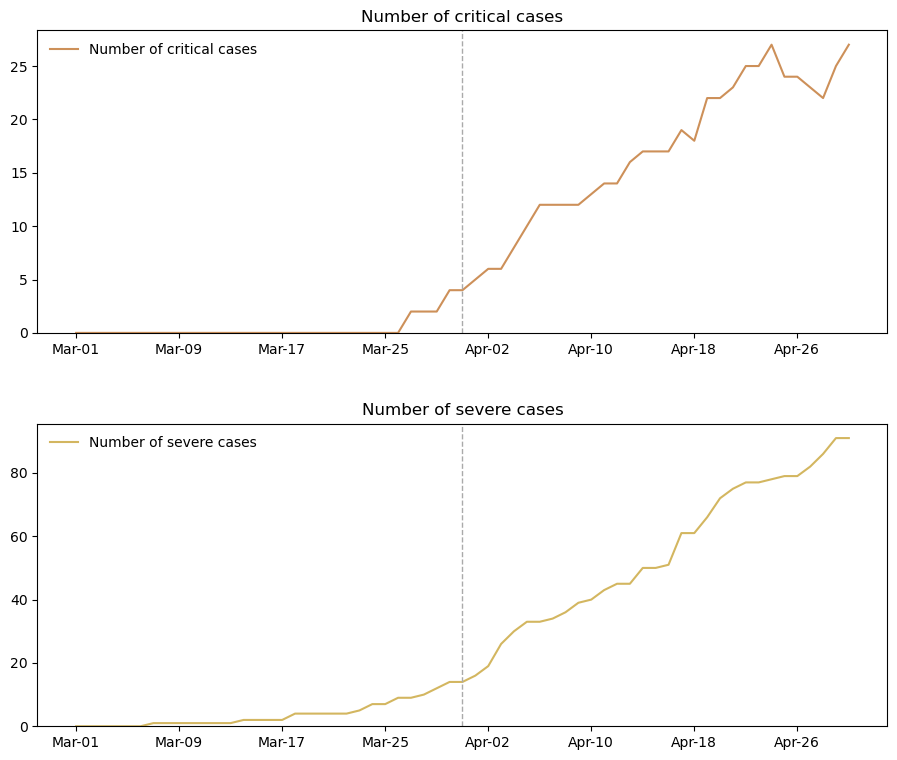

In [13]:
# Vaccine
covishield = cv.vaccinate_prob(vaccine='covishield', days=30, prob=0.7)
sim = cv.Sim(interventions=covishield, use_waning=True).run()
sim.plot(to_plot=['n_critical', 'n_severe'])

In [14]:
# See what can be realized 

In [15]:
pars = dict(
    start_day = '2021-04-01',
    end_day = '2021-07-31',
    
    pop_type = 'hybrid', # Use a more realistic population model
    location = 'India-TamilNadu', # Use population characteristics for Tamil-Nadu

    pop_size = 20_000, # Have 100 thousands people total in the population
    pop_scale = 5,
    rescale = True, # What is dynamic scaling here ?
    pop_infected = 1000, # Start with 1000 (1% of the population) infected people

    quar_factor = {'h': 0.6, 's': 0, 'w': 0.2, 'c': 0}, # change this factor after certain day
    quar_period = 7,
)

In [16]:
# Variant 
delta = cv.variant('b16172', days=0)

In [17]:
# Intervantions

school_interv = cv.clip_edges(
    days=0,
    changes=0,        # the changes in the number of contacts (0: no contact, 1: all contact)
    layers='s'        # the layers in which to isolate contacts (s: school, h: household, w: workplace, c: community)
)

test_interv = cv.test_num(
    daily_tests=500,  # number of tests per day
    symp_test=1.5,    # odds ratio of a symptomatic person testing
    quar_test=1.7,    # probability of a person in quarantine testing
    ili_prev=0.2,     # prevalence of influenza-like-illness symptoms in the population
    loss_prob=0.3,    # probability of the person being lost-to-follow-up (0: no one lost to follow-up)
                      # idea: about 30% tested positive people will not receive their results and will continue behaving as symptomatic or asymptomatic agent, also this test count will be added as a test
    test_delay=1,     # days for test result to be known (0: results available instantly)
                      # how is test delay affecting covid spread ? 
    start_day="2021-04-01",
    end_day='2021-07-31'
)

In [18]:
# Vaccine
vaccine_interv = cv.vaccinate_prob(vaccine='az', days=0, subtarget=vaccinate_by_age)

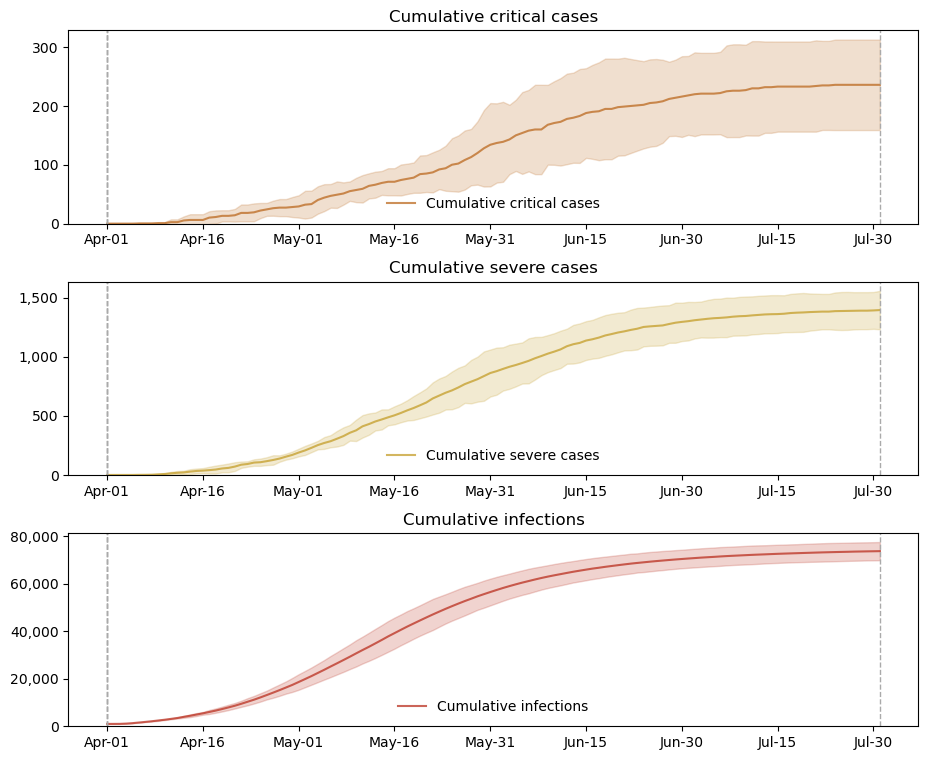

In [19]:
sim = cv.Sim(interventions=[school_interv, test_interv, vaccine_interv], variants=delta, pars=pars, use_waning=True)
msim = cv.MultiSim(sim)
msim.run(n_runs=5)
msim.mean()
msim.plot(to_plot=['cum_critical', 'cum_severe', 'cum_infections'])

In [20]:
# test contact layer
# source:
#  - https://github.com/returaj/covasim/blob/vanilla/covasim/base.py#L1372
#  - https://github.com/returaj/covasim/blob/vanilla/covasim/base.py#L1455

In [ ]:
import networkx as nx

sim = cv.Sim(rand_seed=1, pop_size=50, pop_type='random', contacts={'h':5,'s':0,'w':0,'c':0}, dynam_layer={'h':False}, n_days=5).run()
G = sim.people.contacts.to_graph()

In [ ]:
nx.draw(G)
# nx.degree(G)

In [23]:
# basic test runs

In [24]:
# np.array([1,0,1,0,2]).nonzero()
# l = np.array([True,False,True,True,False,False,True,False])
k = np.array([0,1,3,5])

# k[l[k]]

# np.minimum(k, 4)

# (2**k) * k
# np.exp([2,2], where=[True, False])
# np.array([2,2])/(1 + np.array([2,2]))

# a = np.arange(5); b = np.array([3,5,6,7])
# np.setdiff1d(b, a)

In [25]:
# understanding quarantine

In [26]:
test_interv = cv.test_num(
    daily_tests=5,  # number of tests per day
    symp_test=1.5,    # odds ratio of a symptomatic person testing
    quar_test=1.7,    # probability of a person in quarantine testing
    ili_prev=0.2,     # prevalence of influenza-like-illness symptoms in the population
    loss_prob=0.3,    # probability of the person being lost-to-follow-up (0: no one lost to follow-up)
                        # Not Clear ?
    test_delay=3,     # days for test result to be known (0: results available instantly)
                      # how is test delay affecting covid spread ? 
    start_day="2021-04-01",
    end_day='2021-07-31',
    quar_policy = "start",
    subtarget=vaccinate_by_age
)

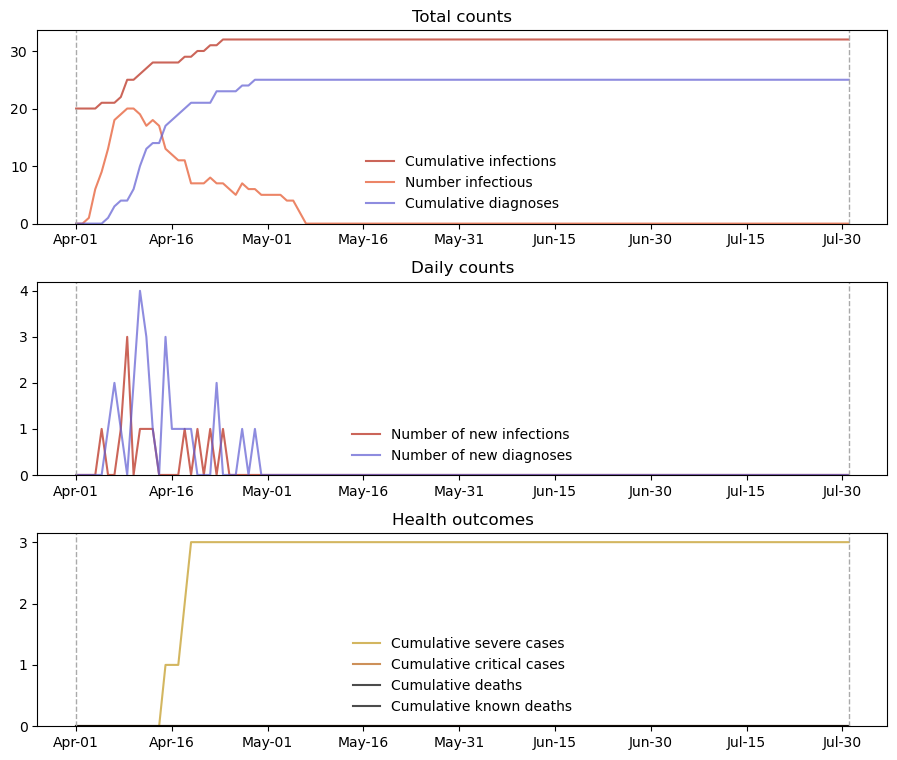

In [27]:
sim = cv.Sim(interventions=[test_interv], pop_size=30, start_day = '2021-04-01', end_day = '2021-07-31', pop_type='hybrid').run()
sim.plot()

In [28]:
sim.people.symptomatic

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])